# Select Kernel

Remember to select the appropriate Kernel and virtual environment to run on.

# Install common packages in Terminal prior to running

pip install pandas
pip install numpy
pip install matplotlib
pip install seaborn
pip install scikit-learn
pip install scipy

To install all of the above at one time: 
pip install pandas numpy matplotlib seaborn scikit-learn scipy


In [2]:
#Load data
import pandas as pd
df = pd.read_csv('2025.09.29_2023_Sales_Transactions_Only.csv')

In [3]:
# Helper: clean numeric/currency columns
# Defines a reusable function to clean currency-like strings and coerce numeric columns.
# Call this early after loading the DataFrame so downstream cells receive numeric columns.

def clean_numeric_columns(df, currency_cols=None, numeric_cols=None, keep_raw=True, overwrite=True):
    import pandas as pd
    if currency_cols is None:
        currency_cols = []
    if numeric_cols is None:
        numeric_cols = []

    def _clean_currency_series(s):
        s2 = s.astype(str).str.strip()
        s2 = s2.replace('nan', '', regex=False)
        # detect parentheses for negatives
        neg_mask = s2.str.match(r'^\(.*\)$')
        # remove parentheses
        s2 = s2.str.replace(r'[\(\)]', '', regex=True)
        # remove dollar signs, commas and whitespace
        s2 = s2.str.replace(r'[\$,\s]', '', regex=True)
        # prefix negatives
        if neg_mask.any():
            s2.loc[neg_mask] = '-' + s2.loc[neg_mask]
        return pd.to_numeric(s2, errors='coerce')

    for col in currency_cols:
        if col in df.columns:
            if keep_raw:
                raw_col = f"{col}_raw"
                # only create raw copy if not exists
                if raw_col not in df.columns:
                    df[raw_col] = df[col]
            cleaned = _clean_currency_series(df[col])
            if overwrite:
                df[col] = cleaned
            else:
                df[f"{col}_clean"] = cleaned

    for col in numeric_cols:
        if col in df.columns:
            coerced = pd.to_numeric(df[col], errors='coerce')
            if overwrite:
                df[col] = coerced
            else:
                df[f"{col}_clean"] = coerced

    return df

# Example call: clean commonly problematic columns
# This will create `Total_Amount_raw` and `Unit_Price_raw` (if they don't exist) and
# create `Total_Amount_clean` and `Unit_Price_clean` columns (originals preserved).
clean_numeric_columns(df,
                      currency_cols=['Total_Amount','Unit_Price'],
                      numeric_cols=['Quantity','Number_of_Scoops','Year','Month'],
                      keep_raw=True,
                      overwrite=False)

print('Completed numeric cleaning: created *_clean columns; raw copies kept if not present.')


Completed numeric cleaning: created *_clean columns; raw copies kept if not present.


# Cleaning README: numeric cleaning contract


This notebook applies a small, deterministic cleaning step to common numeric/currency columns. Contract summary:


- Function: `clean_numeric_columns(df, currency_cols, numeric_cols, keep_raw=True, overwrite=False)`
- Behavior:
  - For each column in `currency_cols` (example: `['Total_Amount','Unit_Price']`):
    - Create `{col}_raw` if `keep_raw=True` and `{col}_raw` does not already exist.
    - Produce a cleaned numeric column named `{col}_clean` (unless `overwrite=True` is used).
    - Cleaning handles: trimming whitespace, removing `$` and `,`, converting `(123.45)` to `-123.45`, and coercing invalid values to `NaN`.
  - For each column in `numeric_cols` (example: `['Quantity','Number_of_Scoops','Year','Month']`):
    - Coerce values to numeric and write to `{col}_clean` (or overwrite original if `overwrite=True`).

- Post-condition: Analysis in this notebook should use `*_clean` columns (e.g., `Total_Amount_clean`, `Unit_Price_clean`, `Quantity_clean`, `Year_clean`, `Month_clean`).
- If `*_clean` is absent, some cells may attempt to create it from `{col}_raw` or, as a last resort, from the original `{col}` with a clear warning — but the preferred source is always `{col}_clean`.

Files produced by the notebook (examples): `total_amount_boxplot.png`, `total_amount_hist.png`.

If you want the cleaned dataset saved to disk, call `df.to_csv('cleaned_sales.csv', index=False)` after verifying the `*_clean` columns.

In [4]:
# Verification: show before/after samples for cleaned columns
print('Column list (first 50):', list(df.columns)[:50])

# Show Total_Amount raw vs clean
if 'Total_Amount_raw' in df.columns:
    print('\nTotal_Amount_raw (first 5):')
    print(df['Total_Amount_raw'].head().to_string())
else:
    print('\nNo Total_Amount_raw column present')

if 'Total_Amount_clean' in df.columns:
    print('\nTotal_Amount_clean (first 5):')
    print(df['Total_Amount_clean'].head().to_string())
    print(f"Total_Amount_clean - non-null count: {df['Total_Amount_clean'].count()} / {len(df)}")
else:
    print('\nNo Total_Amount_clean column present')

# Show Unit_Price raw vs clean
if 'Unit_Price_raw' in df.columns:
    print('\nUnit_Price_raw (first 5):')
    print(df['Unit_Price_raw'].head().to_string())
else:
    print('\nNo Unit_Price_raw column present')

if 'Unit_Price_clean' in df.columns:
    print('\nUnit_Price_clean (first 5):')
    print(df['Unit_Price_clean'].head().to_string())
    print(f"Unit_Price_clean - non-null count: {df['Unit_Price_clean'].count()} / {len(df)}")
else:
    print('\nNo Unit_Price_clean column present')

# Quick numeric summary of cleaned columns
import numpy as np
for c in ['Total_Amount_clean','Unit_Price_clean','Quantity_clean','Number_of_Scoops_clean']:
    if c in df.columns:
        print(f"\nSummary for {c}:")
        print(df[c].describe())
    else:
        print(f"\n{c} not present")


Column list (first 50): ['Transaction_ID', 'Customer_ID', 'Product_ID', 'Date', 'Date 2', 'Quantity', 'Unit_Price', 'Total_Amount', 'Payment_Method', 'Channel', 'Month', 'Year', 'Number_of_Scoops', 'Total_Amount_raw', 'Total_Amount_clean', 'Unit_Price_raw', 'Unit_Price_clean', 'Quantity_clean', 'Number_of_Scoops_clean', 'Year_clean', 'Month_clean']

Total_Amount_raw (first 5):
0     $10.00 
1     $18.00 
2      $9.00 
3     $21.00 
4     $14.00 

Total_Amount_clean (first 5):
0    10.0
1    18.0
2     9.0
3    21.0
4    14.0
Total_Amount_clean - non-null count: 37616 / 37616

Unit_Price_raw (first 5):
0     $5.00 
1     $6.00 
2     $4.50 
3     $7.00 
4     $7.00 

Unit_Price_clean (first 5):
0    5.0
1    6.0
2    4.5
3    7.0
4    7.0
Unit_Price_clean - non-null count: 37616 / 37616

Summary for Total_Amount_clean:
count    37616.000000
mean        11.445582
std          5.310280
min          4.000000
25%          6.500000
50%         11.000000
75%         15.000000
max         22.5

In [5]:
# Quick reload check for the cleaned dataset
import pandas as pd
import os
import hashlib

clean_path = 'cleaned_sales.csv'
print('Checking cleaned file:', clean_path)
if not os.path.exists(clean_path):
    print(f"File not found: {clean_path}. Run the cell that saves the cleaned CSV first.")
else:
    size = os.path.getsize(clean_path)
    # compute sha256 to detect accidental changes
    h = hashlib.sha256()
    with open(clean_path, 'rb') as fh:
        for chunk in iter(lambda: fh.read(8192), b''):
            h.update(chunk)
    sha256 = h.hexdigest()
    print(f"Exists: True  Size(bytes): {size}  SHA256: {sha256}")

    # Load a small sample to validate dtypes quickly
    sample = pd.read_csv(clean_path, nrows=1000)
    print('\nSample load OK — shape (sample):', sample.shape)
    print('\nDtypes (sample):')
    print(sample.dtypes)

    # Lightweight checks on important cleaned columns
    cols = [c for c in ['Total_Amount_clean','Unit_Price_clean','Quantity_clean','Number_of_Scoops_clean','Year_clean','Month_clean'] if c in sample.columns]
    if cols:
        print('\nQuick summary for cleaned columns (sample):')
        print(sample[cols].agg(['count','mean','std']).transpose())
    else:
        print('\nNo expected *_clean columns found in sample — check the saved file and the cleaning steps.')

    print('\nYou can now re-load the full cleaned dataset with: df = pd.read_csv("cleaned_sales.csv")')


Checking cleaned file: cleaned_sales.csv
Exists: True  Size(bytes): 4753284  SHA256: d9131b54ab97b110b70fca59d16dd80ec0ebac479e3b42680b2968a7de47084c

Sample load OK — shape (sample): (1000, 21)

Dtypes (sample):
Transaction_ID             object
Customer_ID                object
Product_ID                 object
Date                       object
Date 2                     object
Quantity                    int64
Unit_Price                 object
Total_Amount               object
Payment_Method             object
Channel                    object
Month                       int64
Year                        int64
Number_of_Scoops            int64
Total_Amount_raw           object
Total_Amount_clean        float64
Unit_Price_raw             object
Unit_Price_clean          float64
Quantity_clean              int64
Number_of_Scoops_clean      int64
Year_clean                  int64
Month_clean                 int64
dtype: object

Quick summary for cleaned columns (sample):
              

In [6]:
#Confirm data load and show cleaned columns (if present)
to_show = []
for c in ['Total_Amount_raw','Total_Amount_clean','Unit_Price_raw','Unit_Price_clean','Quantity_clean','Number_of_Scoops_clean']:
    if c in df.columns:
        to_show.append(c)

if to_show:
    print('Showing head() for cleaned/raw columns:')
    display_cols = df[to_show].head()
    print(display_cols)
else:
    print('No cleaned/raw sample columns present; showing regular head()')
    print(df.head())

Showing head() for cleaned/raw columns:
  Total_Amount_raw  Total_Amount_clean Unit_Price_raw  Unit_Price_clean  \
0          $10.00                 10.0         $5.00                5.0   
1          $18.00                 18.0         $6.00                6.0   
2           $9.00                  9.0         $4.50                4.5   
3          $21.00                 21.0         $7.00                7.0   
4          $14.00                 14.0         $7.00                7.0   

   Quantity_clean  Number_of_Scoops_clean  
0               2                       2  
1               3                       3  
2               2                       1  
3               3                       4  
4               2                       4  


In [7]:
#Confirm dataset volume 
print(df.shape)

(37616, 21)


In [8]:
#(1)DATA UNDERSTANDING 
#Check Data types
print(df.dtypes)

Transaction_ID             object
Customer_ID                object
Product_ID                 object
Date                       object
Date 2                     object
Quantity                    int64
Unit_Price                 object
Total_Amount               object
Payment_Method             object
Channel                    object
Month                       int64
Year                        int64
Number_of_Scoops            int64
Total_Amount_raw           object
Total_Amount_clean        float64
Unit_Price_raw             object
Unit_Price_clean          float64
Quantity_clean              int64
Number_of_Scoops_clean      int64
Year_clean                  int64
Month_clean                 int64
dtype: object


In [9]:
#(2) DATA CLEANING 
#Get missing data per col 
missing_counts_per_column = df.isnull().sum() 

print(missing_counts_per_column)

Transaction_ID               0
Customer_ID                  0
Product_ID                   0
Date                         0
Date 2                       0
Quantity                     0
Unit_Price                   0
Total_Amount                 0
Payment_Method               0
Channel                   7586
Month                        0
Year                         0
Number_of_Scoops             0
Total_Amount_raw             0
Total_Amount_clean           0
Unit_Price_raw               0
Unit_Price_clean             0
Quantity_clean               0
Number_of_Scoops_clean       0
Year_clean                   0
Month_clean                  0
dtype: int64


In [10]:
#(4) OUTLIER DETECTION 
# Prefer working on `Total_Amount_clean`. If missing, attempt to create from
# `Total_Amount_raw`. Only as a last-resort fallback will the original
# `Total_Amount` be used (with a warning).

def _ensure_total_amount_clean(df):
    # If clean exists, nothing to do
    if 'Total_Amount_clean' in df.columns:
        return

    # Try to create from raw copy if it exists
    if 'Total_Amount_raw' in df.columns:
        temp = df['Total_Amount_raw'].astype(str).str.strip()
        temp = temp.replace('nan', '', regex=False)
        neg_mask = temp.str.match(r'^\(.*\)$')
        temp = temp.str.replace(r'[\(\)]', '', regex=True)
        temp = temp.str.replace(r'[\$,\s]', '', regex=True)
        if neg_mask.any():
            temp.loc[neg_mask] = '-' + temp.loc[neg_mask]
        df['Total_Amount_clean'] = pd.to_numeric(temp, errors='coerce')
        print('Created Total_Amount_clean from Total_Amount_raw')
        return

    # Last-resort: if original column exists, create raw and clean but warn
    if 'Total_Amount' in df.columns:
        print('Warning: creating Total_Amount_clean from original Total_Amount (no raw copy present).')
        temp = df['Total_Amount'].astype(str).str.strip()
        temp = temp.replace('nan', '', regex=False)
        neg_mask = temp.str.match(r'^\(.*\)$')
        temp = temp.str.replace(r'[\(\)]', '', regex=True)
        temp = temp.str.replace(r'[\$,\s]', '', regex=True)
        if neg_mask.any():
            temp.loc[neg_mask] = '-' + temp.loc[neg_mask]
        # create raw copy then create clean
        df['Total_Amount_raw'] = df['Total_Amount']
        df['Total_Amount_clean'] = pd.to_numeric(temp, errors='coerce')
        return

    # If we reach here, there's no source to create Total_Amount_clean
    raise RuntimeError('No Total_Amount column (raw or original) found to create Total_Amount_clean')


_ensure_total_amount_clean(df)

# Diagnostics: dtype and count of coerced (NaN) values
print(f"dtype of Total_Amount_clean: {df['Total_Amount_clean'].dtype}")
n_coerced = df['Total_Amount_clean'].isna().sum()
print(f"Number of rows where Total_Amount_clean could not be converted and were set to NaN: {n_coerced}")
if n_coerced > 0:
    print("Sample rows with non-numeric Total_Amount after coercion:")
    print(df[df['Total_Amount_clean'].isna()].head())

# Work with cleaned numeric values only
column_to_analyze = df['Total_Amount_clean'].dropna()

if column_to_analyze.empty:
    print("No numeric values available in 'Total_Amount_clean' after conversion. Cannot compute IQR.")
else:
    # Calculate Q1
    Q1 = column_to_analyze.quantile(0.25)

    # Calculate Q3
    Q3 = column_to_analyze.quantile(0.75)

    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1

    # Define the outlier boundaries (using the standard 1.5 * IQR rule)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print("--- IQR Results for Total_Amount_clean ---")
    print(f"First Quartile (Q1): {Q1}")
    print(f"Third Quartile (Q3): {Q3}")
    print(f"Interquartile Range (IQR): {IQR}")
    print(f"Lower Bound (Outliers below): {lower_bound}")
    print(f"Upper Bound (Outliers above): {upper_bound}")

    # Find and print the outliers using the cleaned column
    outliers = df[(df['Total_Amount_clean'] < lower_bound) | (df['Total_Amount_clean'] > upper_bound)]
    print(f"\nNumber of Outliers Found: {len(outliers)}")
    # Use .head() to avoid printing all rows if you have many outliers
    print(f"First 5 Outlier Transactions:\n{outliers.head()}")

# ----------------------------
# Alternative outlier detection methods and visualization (operate on Total_Amount_clean)
# Create a clean column for alternative analyses if not already present (ensured above)

# 1) Z-score method (use population std, threshold configurable)
mean_val = df['Total_Amount_clean'].mean()
std_val = df['Total_Amount_clean'].std(ddof=0)
if pd.isna(std_val) or std_val == 0:
    z_scores = pd.Series([0]*len(df))
else:
    z_scores = (df['Total_Amount_clean'] - mean_val) / std_val
z_threshold = 3.0
outliers_z = df[z_scores.abs() > z_threshold]
print(f"\nZ-score method (|z| > {z_threshold}): {len(outliers_z)} outliers")

# 2) Trimmed / scaled IQR method (allow multiplier > 1.5)
multiplier = 3.0  # change to 1.5 for standard rule, raise to find more extreme outliers
Q1_t = df['Total_Amount_clean'].quantile(0.25)
Q3_t = df['Total_Amount_clean'].quantile(0.75)
IQR_t = Q3_t - Q1_t
lower_t = Q1_t - multiplier * IQR_t
upper_t = Q3_t + multiplier * IQR_t
outliers_trimmed = df[(df['Total_Amount_clean'] < lower_t) | (df['Total_Amount_clean'] > upper_t)]
print(f"Trimmed IQR method (multiplier={multiplier}): {len(outliers_trimmed)} outliers (bounds {lower_t} to {upper_t})")

# 3) Visualizations: boxplot and histogram (saved to PNG files)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
# Boxplot
plt.figure(figsize=(8,4))
sns.boxplot(x=df['Total_Amount_clean'].dropna())
plt.title('Boxplot of Total_Amount (clean)')
plt.savefig('total_amount_boxplot.png', bbox_inches='tight')
plt.close()
# Histogram with KDE
plt.figure(figsize=(8,4))
sns.histplot(df['Total_Amount_clean'].dropna(), kde=True, bins=30)
plt.title('Histogram of Total_Amount (clean)')
plt.xlabel('Total_Amount')
plt.savefig('total_amount_hist.png', bbox_inches='tight')
plt.close()
print('Saved plots: total_amount_boxplot.png, total_amount_hist.png')

# Print small samples of outliers for quick inspection
print('\nSample outliers by method:')
print('Z-score (first 5):')
print(outliers_z.head().to_string())
print('\nTrimmed IQR (first 5):')
print(outliers_trimmed.head().to_string())
# ----------------------------

dtype of Total_Amount_clean: float64
Number of rows where Total_Amount_clean could not be converted and were set to NaN: 0
--- IQR Results for Total_Amount_clean ---
First Quartile (Q1): 6.5
Third Quartile (Q3): 15.0
Interquartile Range (IQR): 8.5
Lower Bound (Outliers below): -6.25
Upper Bound (Outliers above): 27.75

Number of Outliers Found: 0
First 5 Outlier Transactions:
Empty DataFrame
Columns: [Transaction_ID, Customer_ID, Product_ID, Date, Date 2, Quantity, Unit_Price, Total_Amount, Payment_Method, Channel, Month, Year, Number_of_Scoops, Total_Amount_raw, Total_Amount_clean, Unit_Price_raw, Unit_Price_clean, Quantity_clean, Number_of_Scoops_clean, Year_clean, Month_clean]
Index: []

[0 rows x 21 columns]

Z-score method (|z| > 3.0): 0 outliers
Trimmed IQR method (multiplier=3.0): 0 outliers (bounds -19.0 to 40.5)
Saved plots: total_amount_boxplot.png, total_amount_hist.png

Sample outliers by method:
Z-score (first 5):
Empty DataFrame
Columns: [Transaction_ID, Customer_ID, Prod

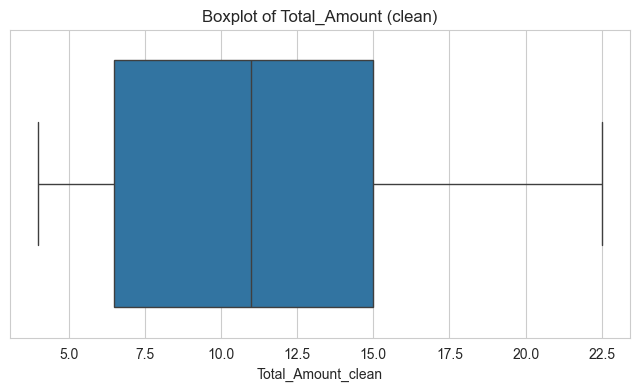

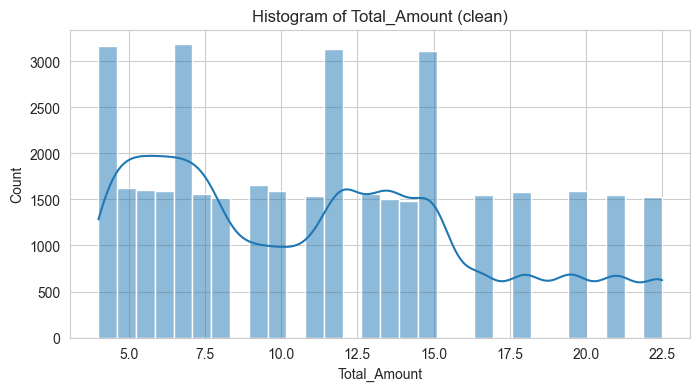

In [11]:
# Display generated plots inline
from IPython.display import Image, display
import os

files = ['total_amount_boxplot.png', 'total_amount_hist.png']
for f in files:
    if os.path.exists(f):
        display(Image(filename=f))
    else:
        print(f"File not found in workspace: {f}")


In [12]:
# (5) CALCULATE AND VISUALIZE DESCRIPTIVE STATISTICS
# Frequency of Year (use Year_clean when available)
year_col = 'Year_clean' if 'Year_clean' in df.columns else 'Year'
frequency_table = df[year_col].value_counts()

print("--- Frequency Count ---")
print(frequency_table)

print("\n--- Relative Frequency (Percentage) ---")
# Get the percentage/proportion of each unique value
relative_frequency_table = df[year_col].value_counts(normalize=True) * 100
print(relative_frequency_table)

# Helper function to get clean column if available
def pick_clean(df, col):
    clean_col = f"{col}_clean"
    return df[clean_col] if clean_col in df.columns else df[col]

# Get clean versions of columns
safe_total = pick_clean(df, 'Total_Amount')
safe_qty = pick_clean(df, 'Quantity')
safe_price = pick_clean(df, 'Unit_Price')
safe_scoops = pick_clean(df, 'Number_of_Scoops')

def safe_print_mean(series, name):
    numeric = pd.to_numeric(series, errors='coerce')
    n_total = len(series)
    n_numeric = numeric.count()
    n_non_numeric = n_total - n_numeric
    mean_val = numeric.mean()
    print(f"{name} Mean: {mean_val} (non-numeric coerced to NaN: {n_non_numeric})")

print("\n--- Column Means ---")
safe_print_mean(safe_total, 'Total_Amount')
safe_print_mean(safe_qty, 'Quantity')
safe_print_mean(safe_price, 'Unit_Price')
safe_print_mean(safe_scoops, 'Number_of_Scoops')

--- Frequency Count ---
Year_clean
2023    37616
Name: count, dtype: int64

--- Relative Frequency (Percentage) ---
Year_clean
2023    100.0
Name: proportion, dtype: float64

--- Column Means ---
Total_Amount Mean: 11.445581667375585 (non-numeric coerced to NaN: 0)
Quantity Mean: 1.9913866439812846 (non-numeric coerced to NaN: 0)
Unit_Price Mean: 5.74670353041259 (non-numeric coerced to NaN: 0)
Number_of_Scoops Mean: 2.4958528285835815 (non-numeric coerced to NaN: 0)


In [13]:
# (5) CALCULATE AND VISUALIZE DESCRIPTIVE STATISTICS
# Frequency of Month AND Year (use cleaned columns when available)
month_col = 'Month_clean' if 'Month_clean' in df.columns else 'Month'
year_col = 'Year_clean' if 'Year_clean' in df.columns else 'Year'
grouped_frequency = df.groupby([month_col, year_col]).size().reset_index(name='Count')

# Get the total number of rows in dataframe
total_count = len(df)

# Calculate the percentage column
grouped_frequency['Percentage'] = (grouped_frequency['Count'] / total_count) * 100

# Rounding to two decimal places
grouped_frequency['Percentage'] = grouped_frequency['Percentage'].round(2)

print("--- Month and Year Frequency ---")
print(grouped_frequency)

--- Month and Year Frequency ---
    Month_clean  Year_clean  Count  Percentage
0             1        2023   1913        5.09
1             2        2023   1800        4.79
2             3        2023   1929        5.13
3             4        2023   1764        4.69
4             5        2023   1671        4.44
5             6        2023   6890       18.32
6             7        2023   7384       19.63
7             8        2023   6579       17.49
8             9        2023   1821        4.84
9            10        2023   1810        4.81
10           11        2023   2013        5.35
11           12        2023   2042        5.43


In [14]:
#(5) CALCULATE AND VISUALIZE DESCRIPTIVE STATISTICS 
#Frenquency of Month AND Year
grouped_frequency = df.groupby(['Month', 'Year']).size().reset_index(name='Count')

#Get the total number of rows in dataframe 
total_count = len(df) 

#Calculate the percentage column
grouped_frequency['Percentage'] = (grouped_frequency['Count'] / total_count) * 100

# Rounding to two decimal places
grouped_frequency['Percentage'] = grouped_frequency['Percentage'].round(2)

print(grouped_frequency)

    Month  Year  Count  Percentage
0       1  2023   1913        5.09
1       2  2023   1800        4.79
2       3  2023   1929        5.13
3       4  2023   1764        4.69
4       5  2023   1671        4.44
5       6  2023   6890       18.32
6       7  2023   7384       19.63
7       8  2023   6579       17.49
8       9  2023   1821        4.84
9      10  2023   1810        4.81
10     11  2023   2013        5.35
11     12  2023   2042        5.43


In [15]:
#(5) CALCULATE AND VISUALIZE DESCRIPTIVE STATISTICS 
#Frenquency of Customer_ID. Aim to confirm there isn't any outliers among customers. 
frequency_table = df['Customer_ID'].value_counts()

print("--- Frequency Count ---")
print(frequency_table)

print("\n--- Relative Frequency (Percentage) ---")
# Get the percentage/proportion of each unique value
relative_frequency_table = df['Customer_ID'].value_counts(normalize=True) * 100

print(relative_frequency_table)

--- Frequency Count ---
Customer_ID
CUST033991    8
CUST014154    8
CUST021510    8
CUST024949    7
CUST014478    7
             ..
CUST013880    1
CUST015906    1
CUST033838    1
CUST023608    1
CUST011906    1
Name: count, Length: 21415, dtype: int64

--- Relative Frequency (Percentage) ---
Customer_ID
CUST033991    0.021268
CUST014154    0.021268
CUST021510    0.021268
CUST024949    0.018609
CUST014478    0.018609
                ...   
CUST013880    0.002658
CUST015906    0.002658
CUST033838    0.002658
CUST023608    0.002658
CUST011906    0.002658
Name: proportion, Length: 21415, dtype: float64


In [16]:
#(5) CALCULATE AND VISUALIZE DESCRIPTIVE STATISTICS 
#Min and Max Customer_ID count. What is the min and max times a customer has attended Crafted Cones? 
import pandas as pd

#Attendance per customer 
attendance_counts = df.groupby('Customer_ID').size().reset_index(name='Attendance_Count')

#Min and max values from the new 'Attendance_Count' column
min_max_attendance = attendance_counts['Attendance_Count'].agg(['min', 'max'])

print("--- Min and Max Customer Attendance ---")
print(min_max_attendance)

--- Min and Max Customer Attendance ---
min    1
max    8
Name: Attendance_Count, dtype: int64


In [17]:
#(5) CALCULATE AND VISUALIZE DESCRIPTIVE STATISTICS 
#Average and Median customer attendance 

# Group by customer attendance count 
attendance_counts = df.groupby('Customer_ID').size().reset_index(name='Attendance_Count')

#Find the mean and median of attendance counts
average_median_attendance = attendance_counts['Attendance_Count'].agg(['mean', 'median'])

print("--- Average and Median Customer Attendance ---")
print(average_median_attendance)

--- Average and Median Customer Attendance ---
mean      1.756526
median    1.000000
Name: Attendance_Count, dtype: float64
